In [2]:
import numpy as np
import tensorflow as tf

import sklearn
import sklearn.datasets
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity


from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib
from matplotlib.colors import ListedColormap
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from IPython import display
import time
%matplotlib inline

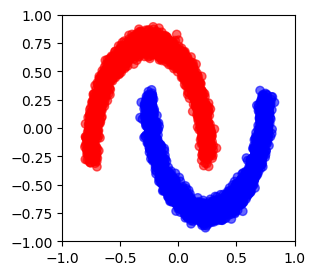

In [3]:
x_train, y_train = sklearn.datasets.make_moons(n_samples=5000, noise=.05)
x_train[:, 1] = x_train[:, 1] * 2
x_train -= .5
x_train = x_train * .5
plt.figure(figsize = (3, 3), dpi=100)
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
plt.scatter(x_train[: , 0], x_train[: , 1], c=y_train, cmap=cm_bright, alpha=0.6)
plt.axis([-1, 1, -1, 1])
plt.show()

In [23]:
X, Y = np.meshgrid(np.linspace(-1, 1, num = 100), np.linspace(-1, 1, num = 100))
grid = np.concatenate((np.reshape(X, (10000, 1)), np.reshape(Y, (10000, 1))), 1)

def get_node0_activation(sess):
    out = sess.run((node), feed_dict = {x_input: grid})
    # Only use the activations of the first node in that layer
    return out[:, 0]

def plot_node_contour(sess, x_input, output, ax, title):
    # Plot the data
    kde = KernelDensity(bandwidth = .05)
    kde.fit(X = x_train)
    I = np.exp(kde.score_samples(grid))
    ax.imshow(np.reshape(I, (100, 100)), cmap = cm.hot)
    
    # Plot the contour
    out = get_node0_activation(sess)
    ax.contour(50 * X + 50, 50 * Y + 50, np.reshape(out, (100, 100)), 20, colors = "w", linestyles = "solid")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)

def plot_node_3d(sess, x_input, output, ax, title):
    out = get_node0_activation(sess)
    surf = ax.plot_surface(X, Y, np.reshape(out, (100, 100)), cmap = cm.coolwarm, lw = 0.5, rstride = 2, cstride = 2, alpha = 0.75)
    CS = ax.contour(X, Y, np.reshape(out, (100, 100)), 30, colors = "k", linestyles = "solid")
    ax.view_init(30, -55)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)
    ax.clabel(CS, inline = 2, fontsize = 24)


def plot_proj(sess, x_input, output, ax, title):
    out = get_node0_activation(sess)
    kde1D2 = KernelDensity(bandwidth = .05)
    kde1D2.fit(np.array([out]).T)
    t = np.linspace(-max(np.abs(out.min()), np.abs(out.max())) * 1.2, max(np.abs(out.min()), np.abs(out.max())) * 1.2, 1000)
    ax.plot(t, np.exp(kde1D2.score_samples(np.array([t]).T)))
    ax.set_title(title)

In [24]:
def weight_variable(shape):
    w = tf.random_normal(shape, dtype=tf.float32, seed=0)
    initial = w/tf.norm(w, axis=0, keepdims=True)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0., shape = shape, dtype=tf.float32)
    return tf.Variable(initial)

def build_mlp_graph(activation_f):
    np.random.seed(123)
    tf.random.set_random_seed(123)
    d = 2
    L1 = 50
    L2 = 100
    L3 = 1

    x_input = tf.placeholder(dtype = tf.float32, shape = (None, d))
    y_input = tf.placeholder(tf.int64, shape = (None))

    theta1 = weight_variable((d, L1))
    b1 = bias_variable((L1, ))
    theta2 = weight_variable((L1, L2))
    b2 = bias_variable((L2, ))
    theta3 = weight_variable((L2, L3))
    b3 = bias_variable((L3, ))
    theta4 = weight_variable((L3, 2))
    b4 = bias_variable((2, ))

    x0 = tf.matmul(x_input, theta1) + b1
    x1 = activation_f(x0)
    x2 = activation_f(tf.matmul(x1, theta2) + b2)
    x3 = activation_f(tf.matmul(x2, theta3) + b3)
    pred = tf.nn.softmax(tf.matmul(x3, theta4) + b4)

    cross_entropy = tf.reduce_mean(-tf.one_hot(y_input, 2) * tf.log(pred))
    train = tf.train.AdamOptimizer(learning_rate = 0.005).minimize(cross_entropy)


    correct_prediction = tf.equal(tf.argmax(pred, 1), y_input)
    acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return (x_input, y_input, train, acc), (x0, x1, x2, x3)

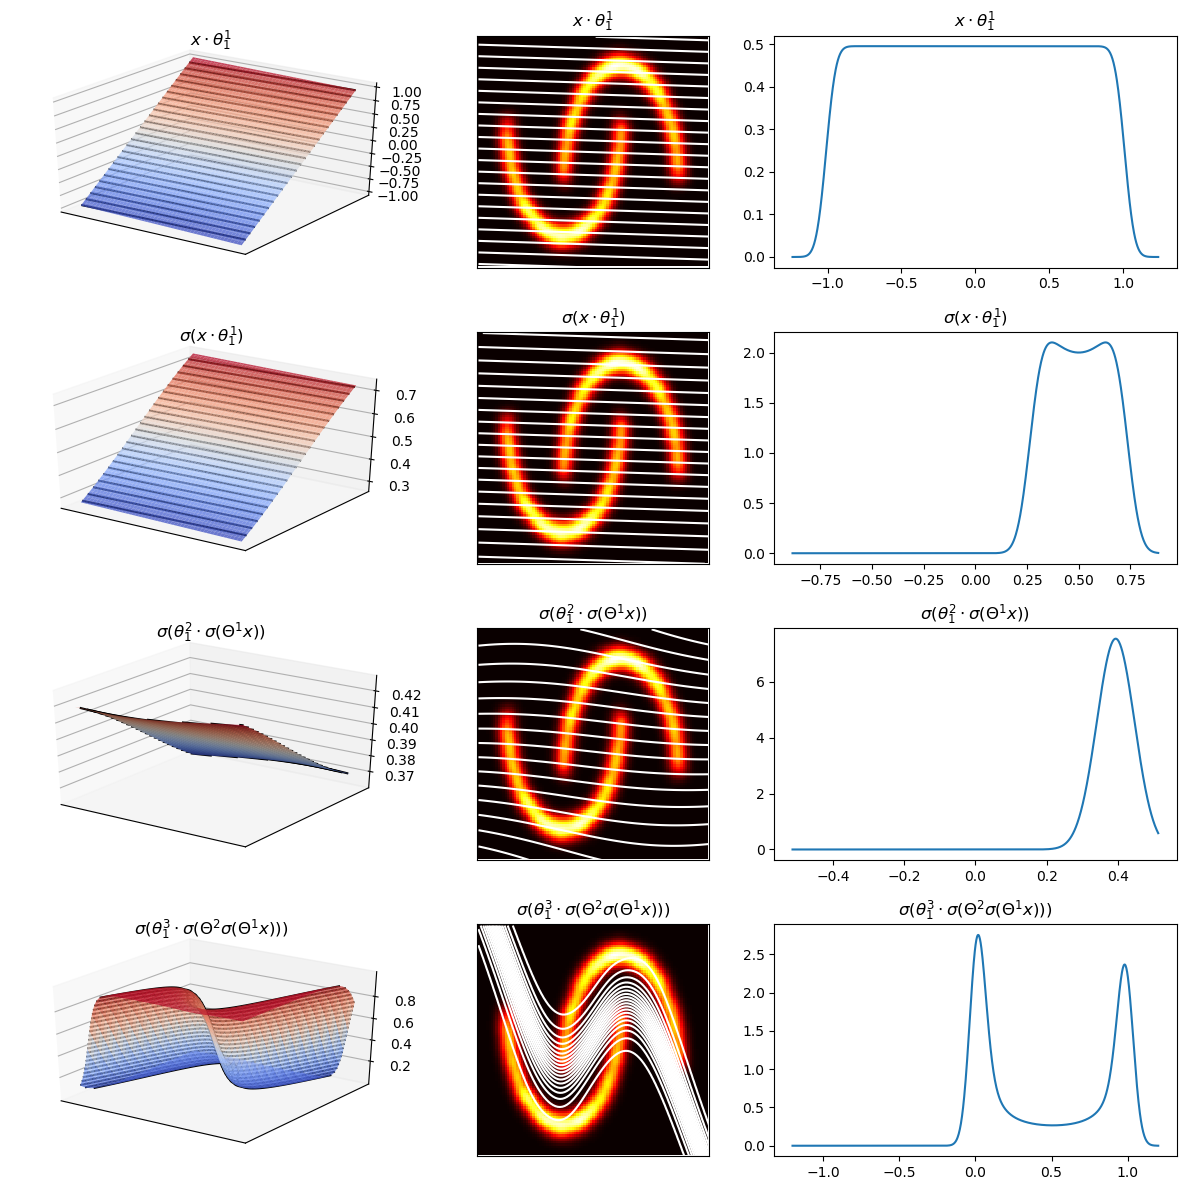

In [26]:
fig = plt.figure(figsize=(12, 12), dpi=100)

with tf.Session() as sess:
    (x_input, y_input, train, acc), nodes = build_mlp_graph(tf.nn.sigmoid)

    sess.run(tf.global_variables_initializer())
    titles = [r'$x\cdot \theta_1^1$',
              r'$\sigma(x\cdot \theta_1^1)$',
              r'$\sigma(\theta_1^2 \cdot \sigma(\Theta^1 x))$',
              r'$\sigma(\theta_1^3 \cdot \sigma(\Theta^2\sigma(\Theta^1 x)))$'
             ]

    for i, node, title in zip(range(4), nodes, titles):
        if i == 3:
            for epoch in range(500):
                _, acc_val = sess.run((train, acc),feed_dict={x_input: x_train, y_input: y_train})
        ax = fig.add_subplot(4, 3, i*3+1, projection='3d')
        plot_node_3d(sess, x_input, node, ax, title)
        ax = fig.add_subplot(4, 3, i*3+2)
        plot_node_contour(sess, x_input, node, ax, title)
        ax = fig.add_subplot(4, 3, i*3+3)
        plot_proj(sess, x_input, node, ax, title)
        plt.tight_layout()


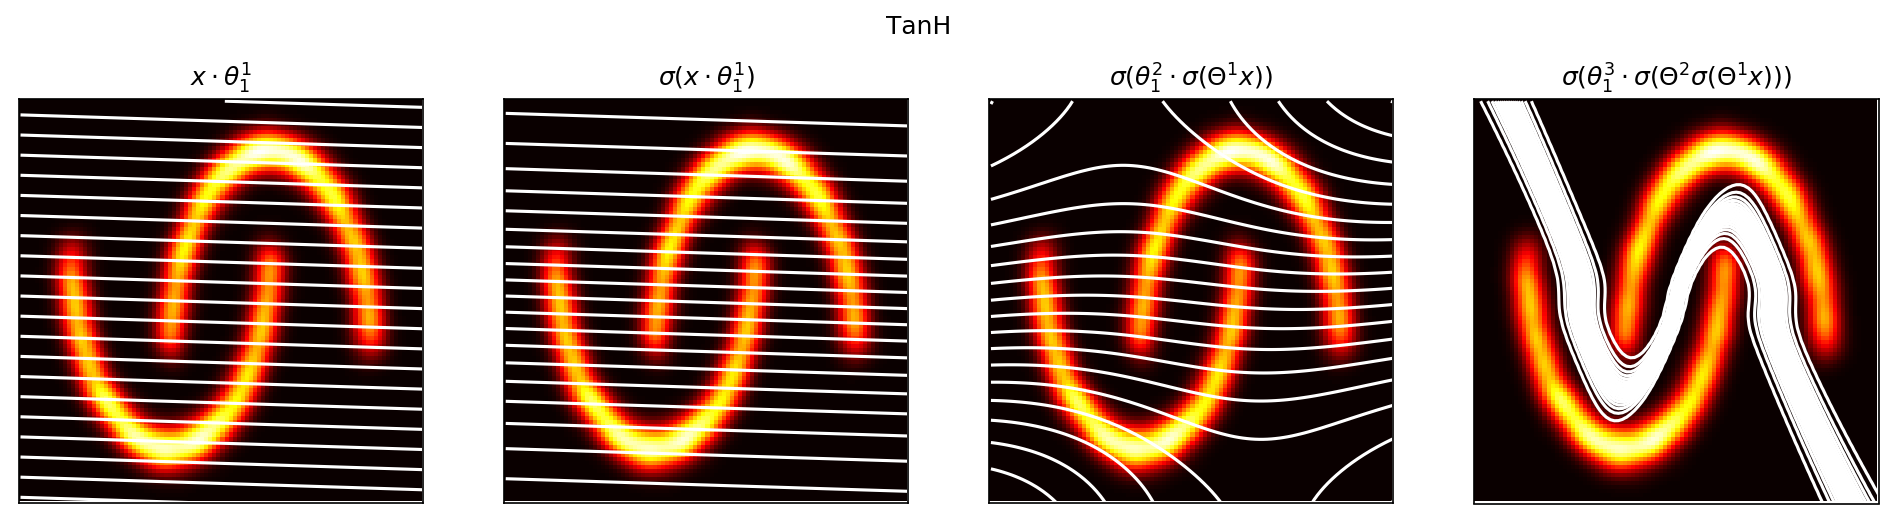

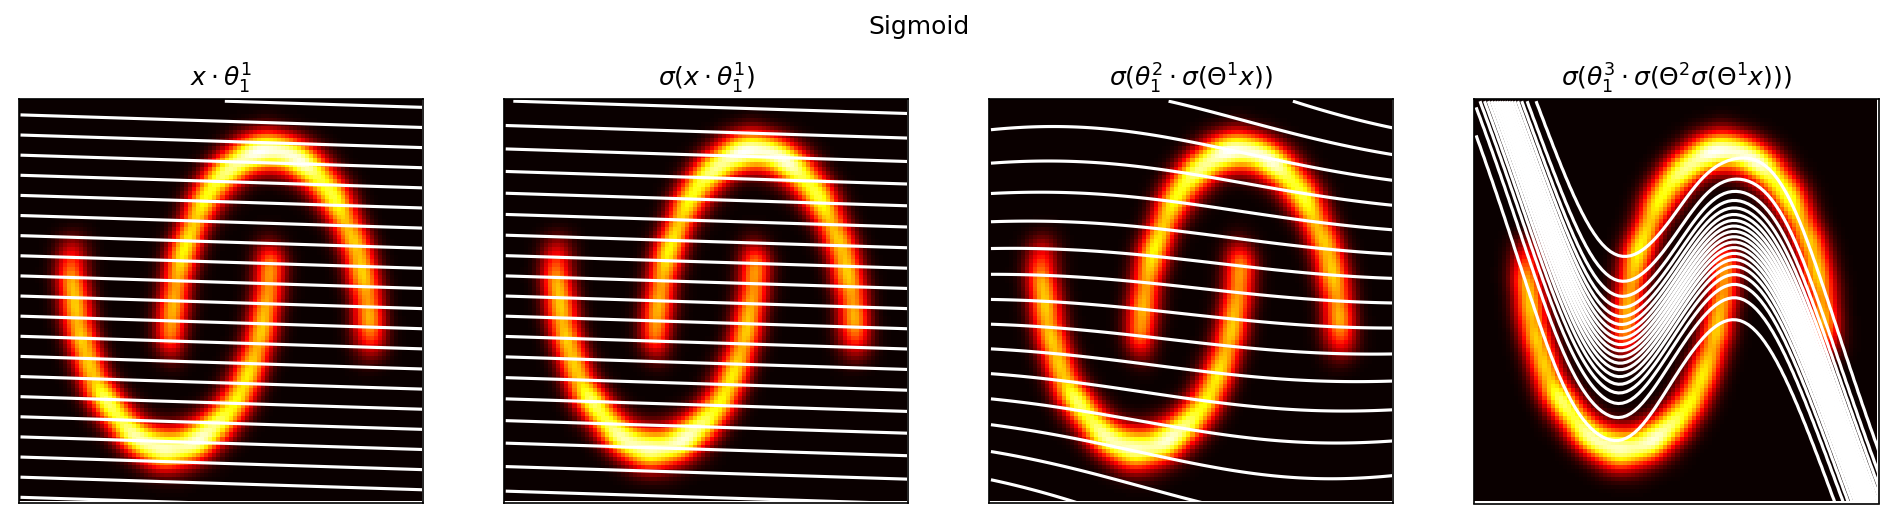

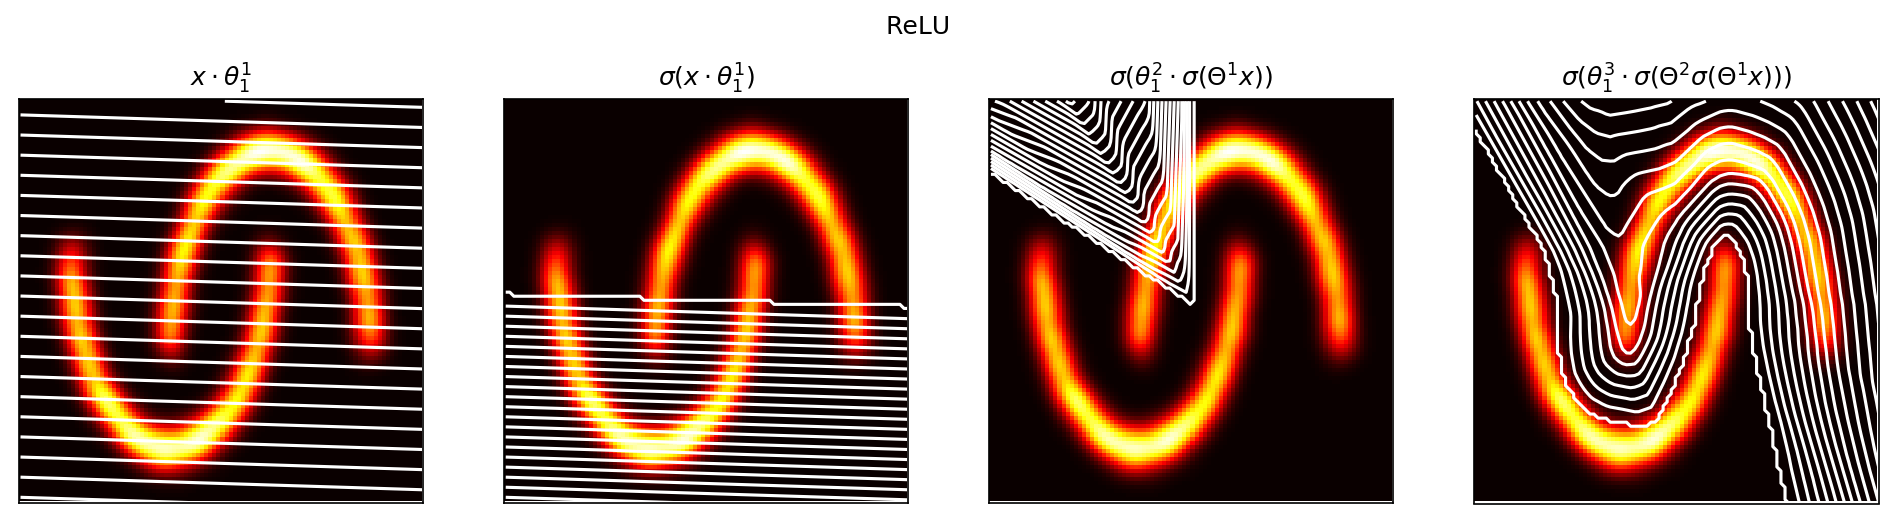

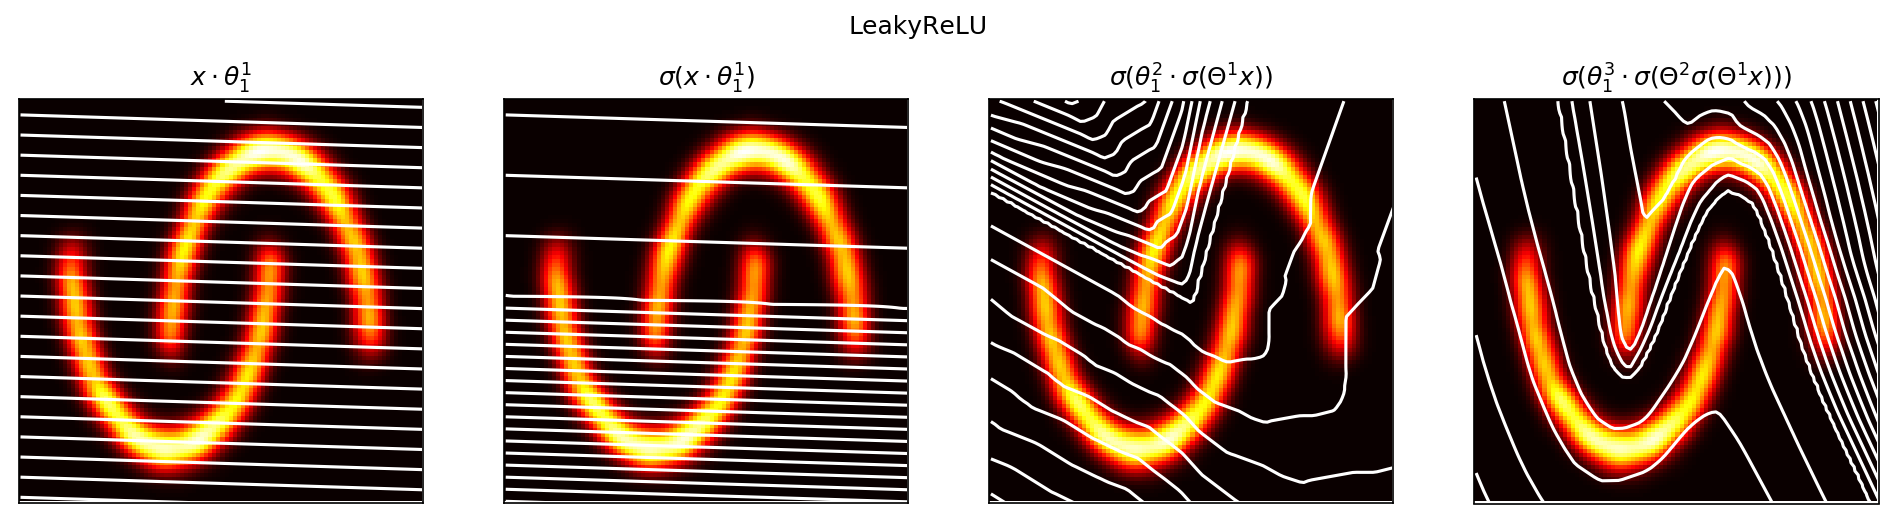

In [21]:


fns = [tf.nn.tanh, tf.nn.sigmoid, tf.nn.relu, tf.nn.leaky_relu]
descs = ['TanH', 'Sigmoid', 'ReLU', 'LeakyReLU']

with tf.Session() as sess:
    for fn, desc in zip(fns, descs):
        (x_input, y_input, train, acc), nodes = build_mlp_graph(fn)
        
        sess.run(tf.global_variables_initializer())
        fig, axes = plt.subplots(ncols=4, figsize=(16, 4), dpi=150)
        titles = [r'$x\cdot \theta_1^1$',
                  r'$\sigma(x\cdot \theta_1^1)$',
                  r'$\sigma(\theta_1^2 \cdot \sigma(\Theta^1 x))$',
                  r'$\sigma(\theta_1^3 \cdot \sigma(\Theta^2\sigma(\Theta^1 x)))$'
                 ]

        for i, ax, node, title in zip(range(4), axes, nodes, titles):
            if i == 3:
                for epoch in range(500):
                    _, acc_val = sess.run((train, acc),feed_dict={x_input: x_train, y_input: y_train})
            plot_node_contour(sess, x_input, node, ax, title)
            plt.suptitle(desc)


